In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [142]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def standarize(data, train_mean, std):
    return (data - train_mean) / std

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mse_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size

In [143]:
class LSTM:
    def __init__(self, input_dimension, hidden_dimension, output_dimension):
        self.input_dimension = input_dimension
        self.hidden_dimension = hidden_dimension
        self.output_dimension = output_dimension

        self.wf = np.random.randn(hidden_dimension, input_dimension + hidden_dimension) * 0.01
        self.bf = np.zeros((hidden_dimension, 1))
        
        self.wi = np.random.randn(hidden_dimension, input_dimension + hidden_dimension) * 0.01
        self.bi = np.zeros((hidden_dimension, 1))
        
        self.wo = np.random.randn(hidden_dimension, input_dimension + hidden_dimension) * 0.01
        self.bo = np.zeros((hidden_dimension, 1))
        
        self.wc = np.random.randn(hidden_dimension, input_dimension + hidden_dimension) * 0.01
        self.bc = np.zeros((hidden_dimension, 1))

        self.wp = np.random.randn(output_dimension, hidden_dimension) * 0.01
        self.bp = np.zeros((output_dimension, 1))

    def step(self, xt, h_prev, c_prev):
        concat = np.vstack((h_prev, xt))

        ft = sigmoid(np.dot(self.wf, concat) + self.bf)
        
        it = sigmoid(np.dot(self.wi, concat) + self.bi)
        c_tilde = np.tanh(np.dot(self.wc, concat) + self.bc)
        
        ct = ft * c_prev + it * c_tilde

        ot = sigmoid(np.dot(self.wo, concat) + self.bo)
        ht = ot * np.tanh(ct)

        cache_t = [ht, ct, ft, it, ot, c_tilde, c_prev, concat]

        return ht, ct, cache_t
    
    def forward(self, x):
        self.T = x.shape[0]
        y_pred = []
        cache = []

        h_prev = np.zeros((self.hidden_dimension, 1))
        c_prev = np.zeros((self.hidden_dimension, 1))

        for t in range(self.T):
            xt = x[t].reshape(-1, 1)
            ht, ct, cache_t = self.step(xt, h_prev, c_prev)
            h_prev, c_prev = ht, ct
            cache.append(cache_t)
            
            yt = np.dot(self.wp, ht) + self.bp
            y_pred.append(yt)

        return np.hstack(y_pred), cache
    
    def backward(self, y_true, y_pred, cache, learning_rate, clip_value):
        dwf, dbf = np.zeros_like(self.wf), np.zeros_like(self.bf)
        dwi, dbi = np.zeros_like(self.wi), np.zeros_like(self.bi)
        dwo, dbo = np.zeros_like(self.wo), np.zeros_like(self.bo)
        dwc, dbc = np.zeros_like(self.wc), np.zeros_like(self.bc)
        dwp, dbp = np.zeros_like(self.wp), np.zeros_like(self.bp)

        dh_next = np.zeros((self.hidden_dimension, 1))
        dc_next = np.zeros((self.hidden_dimension, 1))

        dy = mse_derivative(y_true, y_pred)

        for t in reversed(range(self.T)):
            ht, ct, ft, it, ot, c_tilde, c_prev, concat = cache[t]

            dyt = dy[:, t].reshape(-1, 1)
            dwp += np.dot(dyt, ht.T)
            dbp += dyt

            dht = np.dot(self.wp.T, dyt) + dh_next
            dot = dht * np.tanh(ct)
            dot *= ot * (1 - ot)

            dct = dht * ot * (1 - np.tanh(ct) ** 2) + dc_next
            dc_tilde = dct * it
            dc_tilde *= (1 - c_tilde ** 2)

            dft = dct * c_prev
            dft *= ft * (1 - ft)
            
            dit = dct * c_tilde
            dit *= it * (1 - it)

            dwf += np.dot(dft, concat.T)
            dwi += np.dot(dit, concat.T)
            dwo += np.dot(dot, concat.T)
            dwc += np.dot(dc_tilde, concat.T)
            
            dbf += dft
            dbi += dit
            dbo += dot
            dbc += dc_tilde

            d_concat = (
                np.dot(self.wf.T, dft) + 
                np.dot(self.wi.T, dit) + 
                np.dot(self.wo.T, dot) + 
                np.dot(self.wc.T, dc_tilde)
            )

            dh_next = d_concat[:self.hidden_dimension, :]
            dc_next = dct * ft

        for grad in [dwf, dwi, dwo, dwc, dwp, dbf, dbi, dbo, dbc, dbp]:
            np.clip(grad, -clip_value, clip_value, out=grad)

        self.wf -= learning_rate * dwf
        self.wi -= learning_rate * dwi
        self.wo -= learning_rate * dwo
        self.wc -= learning_rate * dwc
        self.wp -= learning_rate * dwp
        
        self.bf -= learning_rate * dbf
        self.bi -= learning_rate * dbi
        self.bo -= learning_rate * dbo
        self.bc -= learning_rate * dbc
        self.bp -= learning_rate * dbp

    def train(self, x, y, epochs, learning_rate, clip_value):
        loss_list = []
        for epoch in range(epochs):
            epoch_loss = 0
            y_pred, cache = self.forward(x)
            loss = mse(y, y_pred)
            epoch_loss += loss
            self.backward(y, y_pred, cache, learning_rate, clip_value)
            loss_list.append(epoch_loss / x.shape[0])
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}, Loss: {loss}")
        return loss_list

In [144]:
file_path = '../../Datasets/조업편차분석.csv'
data = pd.read_csv(file_path)

data['Origin'] = data.index
shuffled_data = data.sample(frac=1, random_state=42).reset_index(drop=True)

train_size = int(len(shuffled_data) * 0.8)
train_data, test_data = shuffled_data.iloc[:train_size], shuffled_data.iloc[train_size:]

x_train, y_train = train_data.drop(columns=['No.', 'A1', 'Origin'], axis=1), train_data['A1']

x_train_mean = np.mean(x_train, axis=0)
x_train_std = np.std(x_train, axis=0)
y_train_mean = np.mean(y_train, axis=0)
y_train_std = np.std(y_train, axis=0)

x_train = standarize(x_train, x_train_mean, x_train_std).to_numpy()
y_train = standarize(y_train, y_train_mean, y_train_std).to_numpy().reshape(1, -1)

test_data_sorted = test_data.sort_values(by='Origin').reset_index(drop=True)
x_test_sorted, y_test_sorted = test_data_sorted.drop(columns=['No.', 'A1', 'Origin'], axis=1), test_data_sorted['A1']

x_test_sorted = standarize(x_test_sorted, x_train_mean, x_train_std).to_numpy()
y_test_sorted = standarize(y_test_sorted, y_train_mean, y_train_std).to_numpy().reshape(1, -1)

In [145]:
y_train.shape

(1, 6076)

In [146]:
model = LSTM(
    input_dimension=53, 
    hidden_dimension=100,
    output_dimension=1
)

In [147]:
loss_list = model.train(x_train, y_train, 1000, 0.01, 1.0)

Epoch 100, Loss: 0.913310427282301
Epoch 200, Loss: 0.5569432518116355
Epoch 300, Loss: 0.29127464176372686
Epoch 400, Loss: 0.19955140939362362
Epoch 500, Loss: 0.1516639591933234
Epoch 600, Loss: 0.11957728159230557
Epoch 700, Loss: 0.09632170591737188
Epoch 800, Loss: 0.07891037213991083
Epoch 900, Loss: 0.06561999040222515
Epoch 1000, Loss: 0.055344673183373334


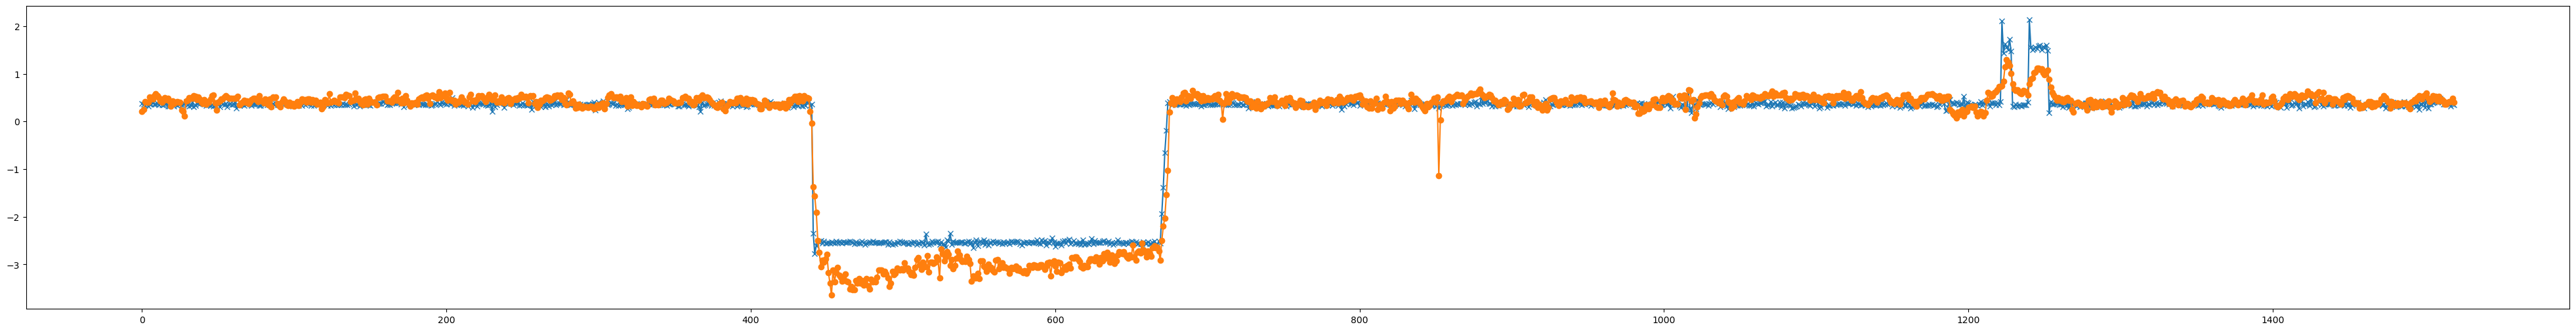

In [154]:
y_pred, _ = model.forward(x_test_sorted)

plt.figure(figsize=(50, 6))
plt.plot(y_test_sorted.reshape(-1, 1), marker="x")
plt.plot(y_pred.reshape(-1, 1), marker="o")
plt.show()

In [149]:
def calculate_metrics(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return r2, rmse, mae, mape

calculate_metrics(y_test_sorted, y_pred)

(0.9384548131721693,
 0.26231249272735263,
 0.1719469272415883,
 28.84702667135211)

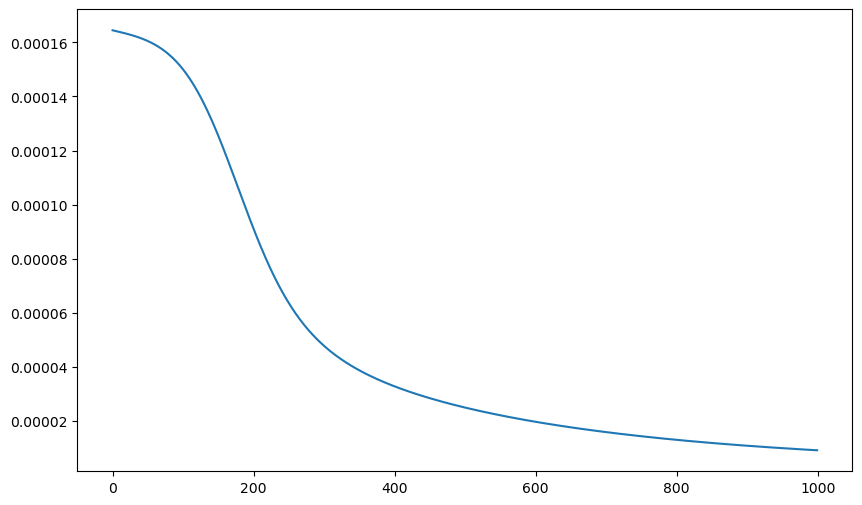

In [150]:
plt.figure(figsize=(10, 6))
plt.plot(loss_list)
plt.show()